In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from torchvision.ops import misc as misc_nn_ops


from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, BackboneWithFPN
from torchvision.models.resnet import resnet101

from matplotlib import pyplot as plt

DIR_INPUT =''
DIR_TRAIN ='train'
DIR_TEST = 'test'

WEIGHTS_FILE = 'model/fasterrcnn_resnet101_26wAnno.pth'

In [2]:
test_df = pd.read_csv('sample_submission.csv')

In [3]:
print(test_df.shape)
print(test_df.head())

(10, 2)
    image_id PredictionString
0  aac893a91    1.0 0 0 50 50
1  51f1be19e    1.0 0 0 50 50
2  f5a1f0358    1.0 0 0 50 50
3  796707dd7    1.0 0 0 50 50
4  51b3e36ab    1.0 0 0 50 50


In [4]:
class WheatTestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        return image, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [5]:
def get_test_transforms():
    return A.Compose([ToTensorV2(p=1.0)])

In [6]:
backbone = resnet101(pretrained=False, norm_layer = misc_nn_ops.FrozenBatchNorm2d)
backbone.load_state_dict(torch.load('resnet101.pth'))

<All keys matched successfully>

In [7]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
#backbone = resnet_fpn_backbone('resnet101', pretrained=False)
#backbone.load_state_dict(torch.load('resnet101.pth'))
layers_to_train = ['layer4', 'layer3', 'layer2', 'layer1', 'conv1'][:3]

for name, parameter in backbone.named_parameters():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)

return_layers = {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}


backbone.out_channels = 256

in_channels_stage2 = backbone.inplanes // 8
in_channels_list = [
    in_channels_stage2,
    in_channels_stage2 * 2,
    in_channels_stage2 * 4,
    in_channels_stage2 * 8,
]
out_channels = 256
backbone_fpn = BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)

In [8]:
model = FasterRCNN(backbone_fpn, num_classes=2)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#model.load_state_dict(torch.load(WEIGHTS_FILE))

num_classes = 2
#model.load_state_dict(torch.load('resnet101.pth'))
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(WEIGHTS_FILE))

model.eval()

x= model.to(device)

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transforms())

test_data_loader = DataLoader(
    test_dataset,
    batch_size = 4,
    shuffle = False,
    num_workers = 4,
    drop_last = False,
    collate_fn = collate_fn
)

In [11]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
        
    return " ".join(pred_strings)

In [12]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:
    
    images = list(image.to(device) for image in images)
    outputs = model(images)
    
    for i, image in enumerate(images):
        
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        
        results.append(result)
        
        

/home/oz/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [13]:
results[0:2]

[{'image_id': 'aac893a91',
  'PredictionString': '0.9976 71 0 101 164 0.9949 694 389 119 175 0.9936 243 84 138 149 0.9926 616 918 77 103 0.9914 551 526 134 196 0.9901 739 769 76 117 0.9897 823 708 100 202 0.9875 180 560 113 208 0.9815 61 857 126 71 0.9805 542 67 151 191 0.9767 601 772 81 125 0.9763 29 453 93 150 0.9689 234 839 108 86 0.9655 459 853 81 100 0.9478 82 617 126 73 0.9423 320 863 79 98 0.9390 333 664 112 150 0.9253 307 0 69 66 0.8972 833 628 77 126 0.8097 363 533 89 80 0.7724 362 266 114 155'},
 {'image_id': '51f1be19e',
  'PredictionString': '0.9884 840 278 130 185 0.9879 611 87 152 165 0.9739 655 788 104 81 0.9659 31 0 83 71 0.9580 814 764 91 85 0.9545 275 470 134 117 0.9305 347 132 92 185 0.9226 573 602 99 107 0.9102 509 469 188 99 0.9036 768 888 136 85 0.8903 700 922 75 80 0.8752 664 580 98 92 0.8735 215 935 78 87 0.8580 822 90 94 82 0.7618 0 386 45 105 0.7129 255 121 76 109 0.6728 911 691 98 76 0.6093 69 689 115 209'}]

In [14]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df

,image_id,PredictionString
0,aac893a91,0.9976 71 0 101 164 0.9949 694 389 119 175 0.9...
1,51f1be19e,0.9884 840 278 130 185 0.9879 611 87 152 165 0...
2,f5a1f0358,0.9956 943 431 79 188 0.9940 888 644 86 143 0....
3,796707dd7,0.9927 0 452 65 74 0.9906 900 332 105 92 0.990...
4,51b3e36ab,0.9967 236 647 87 153 0.9962 840 443 183 152 0...
5,348a992bb,0.9962 541 32 72 95 0.9954 731 225 139 82 0.99...
6,cc3532ff6,0.9982 773 831 160 157 0.9977 377 0 82 98 0.99...
7,2fd875eaa,0.9990 104 583 141 85 0.9984 0 911 104 81 0.99...
8,cb8d261a3,0.9965 23 565 179 98 0.9962 755 713 80 83 0.99...
9,53f253011,0.9988 931 200 91 135 0.9970 932 807 92 207 0....


In [15]:
images[1].shape

torch.Size([3, 1024, 1024])

In [16]:
sample = images[0].permute(1,2,0).cpu().numpy()
boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


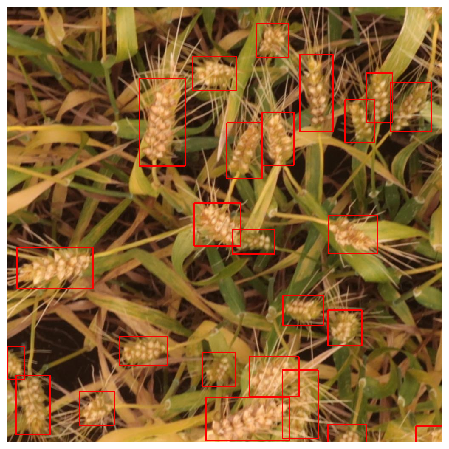

In [17]:
fig, ax = plt.subplots(1, 1 , figsize = (16, 8))

for box in boxes:
    cv2.rectangle(sample, 
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220,0,0),2)
    
ax.set_axis_off()
ax.imshow(sample)

In [20]:
test_df.to_csv("submission.csv", index=False)